# Exercise 4 - Spam Filtering with Naive Bayes

In this Exercise we will implement a spam detector that relies on the naive Bayes assumption. We will then compare its performance to logistic regression.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        10.05.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Dataset

We will use the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download). You find this dataset as `spam_data.csv`. Each line consists of a message together with a label:
- spam (message is a spam message)
- ham (message is legitimate)

### Task 1
Find a way to load the dataset and transform the features `X` (SMS) and the labels `Y` (spam/ham) into numerical representations.

Hint:

For transforming SMS into features, check out the bag of words representation from [scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html)

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the CSV file into a pandas dataframe
data = pd.read_csv('spam_data.csv', encoding='latin-1')

# Extract the SMS messages and labels from the dataframe
X = data['v2']
Y = data['v1']

# Convert the SMS messages into bag-of-words representations
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).toarray()

print(Y)

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object


# Naive Bayes

The naive Bayes filter is based on the Bayes formula with an additional simplifying (naive) assumption about the nature of the likelihood.

Let $S = \{\text{spam}, \text{ham}\}$ be the source of a SMS and $W = [w_1,\dots w_k]$ be the sequence of words contained in the SMS.
Then filtering for spam and ham is done by evaluating the posterior distribution
\begin{align}
P(S|W)&=\cfrac{P(S)P(W|S)}{P(W)}
\end{align}

Lets look at the single parts of the equations right hand side and how to implement them.

As a running example we will use $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$.

## Prior $P(S)$

The prior distribution $P(S)$ is independent of the message $W$. We will use the maximum likelihood (ML) estimate for a categorical distribution, which is the relative frequency of the categories among the dataset.
\begin{align}
P(S = \text{spam})_{ML} &= \cfrac{\text{# SMS that are spam}}{\text{# SMS}}\\
P(S = \text{ham})_{ML} &= 1 - P(S = \text{spam})
\end{align}

### Task 2

Estimate $P(S)$. Display the estimated distribution in a bar chart.

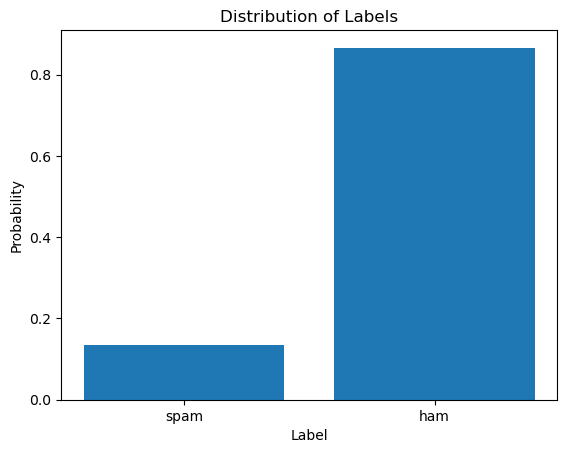

In [11]:
# estimate P(S), display in bar chart
import matplotlib.pyplot as plt

label_counts = Y.value_counts()
P_spam = label_counts['spam']/len(Y)
P_ham = 1-P_spam

fig, ax = plt.subplots()
ax.bar(['spam', 'ham'], [P_spam, P_ham])
ax.set_xlabel('Label')
ax.set_ylabel('Probability')
ax.set_title('Distribution of Labels')
plt.show()

## Likelihood P(W|S)

The likelihood distribution models how likely a SMS is, given we know its either spam or ham.

E.g. for $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$ we would expect something like 
\begin{align}
P(W|S=\text{spam}) &= \text{low}\\
P(W|S=\text{ham}) &= \text{medium}\\
\end{align}

However to estimate $P(W|S)$ we would need a dataset with the exact same $W$ appearing in both contexts: spam and ham. Since this is not the case for our dataset, this is the part where we make a naive assumption:
\begin{align}
P(W|S) = \prod_{w\in W}P(w|S)
\end{align}
That is, we consider each word in the SMS text independend of the others. This simplification enables us to estimate the likelihood, since single words to in fact appear in both contexts.

For a single word $w$, we can again estimate the probability as relative frequency 
\begin{align}
P(w|S = \text{spam})_{ML} &= \cfrac{\text{# word $w$ is labeled spam}}{\text{# any word is labeled spam}}\\
P(w|S = \text{ham})_{ML} &= \cfrac{\text{# word $w$ is labeled ham}}{\text{# any word is labeled ham}}\\
\end{align}

Since we cannot expect every word to have appeared in a spam and ham message, we will smooth our dataset with a [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) of $\varepsilon = 0.01$. 

This is done by adding $\varepsilon$ to the count of every word in every SMS.

As an example the count vector for a SMS over a vocabulary of 5 words is transformed from
\begin{align}
[1, 2, 0, 0, 1]
\end{align}
into
\begin{align}
[1.001, 2.001, 0.001, 0.001, 1.001]\,.
\end{align}

This way we do not have zero probabilities in the product for calculating $P(W|S)$.

### Task 3

Apply Laplace smoothing ($\varepsilon = 0.001$) to the dataset.

In [12]:
# apply Laplace smoothing
X = X + 0.001

### Task 4

For $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$, calculate $P(W|S)$.

Display $P(w|S = \text{spam}), P(w|S = \text{ham})$ for every $w\in W$.

7.686863643235675e-15
1.4795368564039832e-15


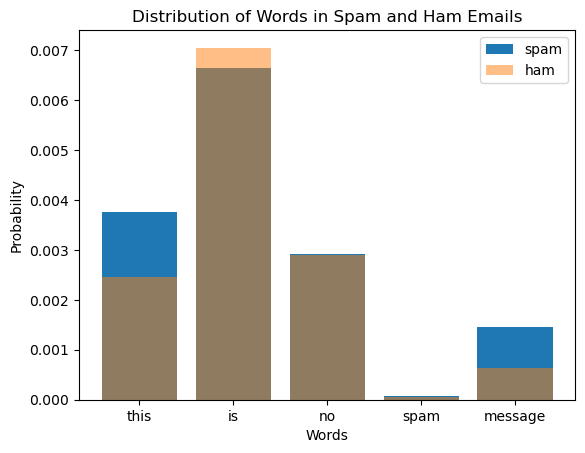

In [13]:
# calculate P(W|S) for W = [this is no spam message]
from sklearn.preprocessing import LabelEncoder

W = ['this','is','no','spam','message']

spam = []
ham = []

le = LabelEncoder()
Y = le.fit_transform(Y).T

X_spam = X[Y==1]
X_ham = X[Y==0]

# calculate probs
for w in W:
    a = X_spam[:, vectorizer.vocabulary_[w]].sum()
    b = X_ham[:, vectorizer.vocabulary_[w]].sum()
    spam.append(a / X_spam.sum())
    ham.append(b / X_ham.sum())
    
#calculate spam prob
p_W_spam = 1
for i in range(5):
    p_W_spam *= spam[i]
print(p_W_spam)

#calculate ham prob
p_W_ham = 1
for i in range(5):
     p_W_ham *= ham[i]
print(p_W_ham)

p_W_S = [p_W_spam, p_W_ham]

fig, ax = plt.subplots()
ax.bar(W, spam, label='spam')
ax.bar(W, ham, label='ham', alpha=0.5)
ax.set_xlabel('Words')
ax.set_ylabel('Probability')
ax.set_title('Distribution of Words in Spam and Ham Emails')
ax.legend()
plt.show()

### Task 5
From the dataset, list the top 5 words with the highest probabilities $P(w|S = \text{spam})$ and $P(w|S = \text{ham})$.

In [15]:
import numpy as np

# list top 5 words accoding to P(w|S)
tmp = X_spam.sum(axis = 0)/X_spam.sum()
highest_probs_spam = []
    
for i in range(5):
    max = np.argmax(tmp)
    tmp[max] = 0
    highest_probs_spam.append(vectorizer.get_feature_names_out()[max])

tmp = X_ham.sum(axis = 0)/X_ham.sum()
highest_probs_ham = []

for i in range(5):
    max = np.argmax(tmp)
    tmp[max] = 0
    highest_probs_ham.append(vectorizer.get_feature_names_out()[max])

print(highest_probs_spam)
print(highest_probs_ham)

['to', 'call', 'you', 'your', 'free']
['you', 'to', 'the', 'and', 'in']


## Evidence $P(W)$

The evidence tells us how likely the SMS was anyway. In many cases this is the most difficult part of the posterior to calculate. Here however we are lucky, since there are only two cases for $S$ and therefore
\begin{align}
P(W) = P(W|S=\text{spam}) + P(W|S=\text{ham})
\end{align}

That is $P(W)$ acts as a normalization constant.

### Task 6

For $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$, calculate $P(W)$.

In [17]:
# calculate P(W) for W = [this is no spam message]
print(f'P(W) = ', p_W_S[0] + p_W_S[1])

P(W) =  9.16640049963966e-15


## Classification

With Prior, Likelihood and Evidence we can now assemble the Posterior
\begin{align}
P(S|W)&=\cfrac{P(S)P(W|S)}{P(W)}\,.
\end{align}

Remember that we want to use the Posterior to classify $W$:
\begin{align}
\kappa(W) = \begin{cases}
\text{spam}&\text{, if }P(S = \text{spam}|W) \geq P(S = \text{ham}|W)\\
\text{ham}&\text{, else}
\end{cases}
\end{align}

### Task 7

Implement the following `NaiveBayes` class. 

Use it to fit and predict on the dataset.

In [20]:
class NaiveBayes():
    
    def __init__(self):
        '''
        Class for binary naive Bayes.
        '''
        self.p_spam = None
        self.p_ham = None
        self.spam_probs = None
        self.ham_probs = None
    
    def fit(self, X : np.ndarray, y : np.ndarray, eps : float = 0.0001):
        '''
        Given a dataset of count vectors, calculates probabilities needed for prediction.
        
        @Params:
            X... word count matrix (# SMS x # words)
            y... label matrix (# SMS)
            eps... parameter for laplace smoothing
        '''
        # perform laplace smoothing on X
        X = X + eps
        
        # divide X into spam / ham 
        X_spam = X[y == 1]
        X_ham = X[y == 0]
        
        # calculate p(S)
        self.p_spam = y.sum()/len(y)
        self.p_ham = 1 - self.p_spam
        
        # calculate word counts
        spam_counts = X_spam.sum(axis = 0)
        ham_counts = X_ham.sum(axis = 0)
        
        # calculate word probabilities
        self.spam_probs = spam_counts/X_spam.sum()
        self.ham_probs = ham_counts/X_ham.sum()
        

    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Given a dataset of count vectors, predicts labels.
        
        @Params:
            X... word count matrix (# SMS x # words)
            
        @Returns:
            array of predictions for labels (0 = ham, 1 = spam)
        '''
        y = np.ndarray([])
        
        # use log to avoid multiplying by 0, ignore denominator bc it's the same for both probs
        
        log_p_s_w = (X * np.log(self.spam_probs)).sum(axis = 1) + np.log(self.p_spam)
        log_p_h_w = (X * np.log(self.ham_probs)).sum(axis = 1) + np.log(self.p_ham)
        y = (log_p_s_w >= log_p_h_w).astype(int)
        return y
  

    def accuracy(self, X : np.ndarray, y : np.ndarray) -> float:
        '''
        Calculates accuracy for given dataset.
        
        @Params:
            X... word count matrix (# SMS x # words)
            y... label matrix (# SMS)
            
        @Returns:
            accuracy (percentage of correctly classified x)
        '''
        return np.mean(self.predict(X) == y)
    
# fit on dataset, report accuracy
nb = NaiveBayes()
nb.fit(X, Y)

print(nb.accuracy(X, Y))


0.9926417803302225


### Task 8

Obviously we trained on the same dataset as we tested and therefore cannot quite judge the performance of the naive Bayes classifier. 

Split your data into 75% training- and 25% testdata. Use a seed for reproducibility.

In [21]:
# provide train + testsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape)
print(len(y_train))

(4179, 8672)
4179


### Task 9

Now we systematically want to test our classifier. 

For different values of $\varepsilon$ track the accuracy on train and testdata.
Which value for $\varepsilon$ would you recommend?

In [ ]:
report train- and test accuracy for different epsilons
nb.fit(X_train, y_train, 1e-10)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-9)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-8)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-7)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-6)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-5)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-4)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-3)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-2)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1e-1)
print(nb.accuracy(X_test, y_test))

nb.fit(X_train, y_train, 1)
print(nb.accuracy(X_test, y_test))

In [ ]:
# bei eps = 1e-3 ist die höchste accuracy erreicht, wird eps kleiner, wird es nicht wesentlich ungenauer, wird es größer hingegen schon
# das liegt denke ich auch an den größeren Rundungsfehlern bei größeren floats